# ATF-36077 Ultra Low Noise Pseudomorphic HEMT
Bilateral design

In [1]:
import skrf as rf
import numpy as np
import schemdraw
import schemdraw.elements as elm
from skrf import Network,Frequency
from scipy.optimize import minimize
from skrf.media import DistributedCircuit
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib import style
from skrf.data import ring_slot
from cmath import log10,rect
from pylab import *

def Celsius_to_Kelvin(C):
    return (C + 273.15)

def P2R(amplitude, angles):
    nprect = np.vectorize(rect)
    return nprect(amplitude, np.deg2rad(angles))

def R2P(x):
    return abs(x),np.angle(x,deg=True)

def DB10(x):
  # to power DB
  x=abs(x)
  return 10*log10(x)

def FDB10(x):  
  #from power DB
  return round(10**(x/10),3)

def DBm10(x):
    #from power DB
    return DB10(x)+30

def DB20(x):
  # to voltage DB
  x=abs(x)
  return 20*log10(x)

def FDB20(x):  
  #from voltage DB
  return round(10**(x/20),3)

In [2]:
import math

def sensitivity(Temp,bandwidth,noisefig,snr):
    # normaly negative
    Temp=Celsius_to_Kelvin(Temp)
    return DBm10(KTB(Temp,bandwidth))+noisefig+snr

def Bandwidth(s21_list,freq_step):
    sum=0
    for i in s21_list:
        sum=sum+(abs(i)**2)*freq_step
    return sum/(abs(np.amax(s21_list))**2)    
    
def KTB(Temp,bandwidth):
    Temp=Celsius_to_Kelvin(Temp)
    return 1.38065 * 10**-23*Temp*bandwidth

def Thermal_noise_floor(Temp,bandwidth):
    return DBm10(KTB(Temp,bandwidth))

def swr(g):
    return (1+abs(g))/(1-abs(g))
    
def GT(s11,s12,s21,s22,gs,gl):
    # Transducer Gain : 
    # the actual gain of an amplifier stage including the effects of input and output matching and device gain
    qabs = lambda x: np.square(np.absolute(x))
    return (qabs(s21)*(1-qabs(gs))*(1-qabs(gl)))/qabs((1-s11*gs)*(1-s22*gl)-s12*s21*gl*gs)

def Rout(zout,zl):
    "series resistance"
    return -zout.real-zl.real

def Rin(zin,zs):
    "series resistance"
    return -zin.real-zs.real

def findzin(zs):
    zin=-zs
    if zin.real<0:
        return zin
    print("zin real part most be negative")
    return False

def findzout(zl):
    zout=-zl
    if zout.real<0:
        return zout
    print("zout real part most be negative")
    return False

def findzfromgama(g):
    # find z from gama
    return [z0*((g+1)/(1-g)),z0*((-g+1)/(1+g))]

def gamas(zs):
    # zs is unnormalized
    a=(zs-z0)/(zs+z0)
    print("gamas read from smith chart :",R2P(a))
    return a
def gamal(gs):
    return np.conj(s22+((s12*s21*gs)/(1-(s11*gs))))

def MAG(s11,s12,s21,s22):
    # Maximum Available Gain for unconditionaly stable
    delta=(s11*s22)-(s12*s21)
    amps11=abs(s11)**2
    amps22=abs(s22)**2
    ampdelta=abs(delta)**2
    k=(1-amps11-amps22+ampdelta)/(2*abs(s12*s21))
    if k<1:
        raise("it is not unconditionaly stable")
    B1=1+amps11-amps22-ampdelta
    if B1<0:
        MAG=DB10(abs(s21/s12))+DB10(abs(k+math.sqrt(k**2-1)))
    else:                                
        MAG=DB10(abs(s21/s12))+DB10(abs(k-math.sqrt(k**2-1)))
    return MAG                             
    
def rollet(s11,s12,s21,s22):
  delta=(s11*s22)-(s12*s21)
  print('delta:',delta)
  amps11=abs(s11)**2
  amps22=abs(s22)**2
  ampdelta=abs(delta)**2
  k=(1-amps11-amps22+ampdelta)/(2*abs(s12*s21))
  print('k:',k,'|delta|:',abs(delta))
  if amps11<1 and amps22<1 and abs(delta)<1 and k>1:
    print('unconditionally stable')
  else:
    print('potentially unstable check stable circules')  

def mou(s11,s12,s21,s22,verbus=True):
    delta=(s11*s22)-(s12*s21)
    amps11=abs(s11)**2
    mou=(1-amps11)/(abs(s22-(delta*s11.conjugate()))+abs(s12*s21))
    if verbus:
        print('delta:',delta)
        print('mou:',mou)
        if mou>1:
            print('unconditionally stable') 
    return mou

def smithcircule(R):
    fig = go.Figure(go.Scattersmith(imag=np.imag(R), real=np.real(R),marker_color="red",showlegend=True,name='guess'))
    fig.update_layout(height=800,width=1000)
    fig.show()
    
def calc_circle(c, r):
  theta = np.linspace(0, 2*np.pi, 1000)
  return c + r*np.exp(1.0j*theta)

def plotstablecircules(s11,s12,s21,s22,R):
    sqabs = lambda x: np.square(np.absolute(x))
    #plotlist=[]
    delta = (s11*s22) - (s12*s21)
    rl = np.absolute((s12 * s21)/(sqabs(s22) - sqabs(delta)))
    cl = np.conj(s22 - delta*np.conj(s11))/(sqabs(s22) - sqabs(delta))
    print("out (","R:",rl,"C:",R2P(cl),")")
    rs = np.absolute((s12 * s21)/(sqabs(s11) - sqabs(delta)))
    cs = np.conj(s11 - delta*np.conj(s22))/(sqabs(s11) - sqabs(delta))
    print("in (","R:",rs,"C:",R2P(cs),")")
    plt.figure(figsize=(10, 8), dpi=80)
    n = rf.Network(name="out", s=calc_circle(cl, rl))
    n.plot_s_smith(lw=2,draw_labels=True)
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(cl, rl)), real=np.real(calc_circle(cl, rl)),marker_color="green",showlegend=True,name='out'))
    n = rf.Network(name="in", s=calc_circle(cs, rs))
    n.plot_s_smith(lw=2,draw_labels=True)  
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(cs, rs)), real=np.real(calc_circle(cs, rs)),marker_color="red",showlegend=True,name='in'))
    for i in R:
        n = rf.Network(name=str(i), s=calc_circle(0, i))
        n.plot_s_smith(lw=1,draw_labels=True)      
        #plotlist.append(go.Scattersmith(imag=[0], real=[i],showlegend=True,name=str(i)))
    #fig = go.Figure(plotlist)
    #fig.update_layout(height=800,width=1000)
    #fig.show()      
    if abs(s11)<1 and abs(s22)<1:
        print('hole smith except circles')
    else:
        print('inside of circles')   

def gain_ciecles(s11,gama_s,s22,gama_l,guess):
    sqabs = lambda x: np.square(np.absolute(x))
    #plotlist=[]
    gs=(( 1-sqabs(gama_s) / sqabs(1-s11*gama_s)))*(1-sqabs(s11))
    gl=(( 1-sqabs(gama_l) / sqabs(1-s22*gama_l)))*(1-sqabs(s22))

    Cs = (gs*np.conjugate(s11))/(1-(1-gs)*sqabs(s11))
    Rs = (np.sqrt(1-gs)*(1-sqabs(s11)))/(1-(1-gs)*sqabs(s11))

    Cl = (gl*np.conjugate(s22))/(1-(1-gl)*sqabs(s22))
    Rl = (np.sqrt(1-gl)*(1-sqabs(s22)))/(1-(1-gl)*sqabs(s22))

    plt.figure(figsize=(10, 8), dpi=80)
    n = rf.Network(name="out", s=calc_circle(Cl, Rl))
    n.plot_s_smith(lw=2,draw_labels=True)
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(Cl, Rl)), real=np.real(calc_circle(Cl, Rl)),marker_color="green",showlegend=True,name='out'))
    n = rf.Network(name="in", s=calc_circle(Cs, Rs))
    n.plot_s_smith(lw=2,draw_labels=True)
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(Cs, Rs)), real=np.real(calc_circle(Cs, Rs)),marker_color="red",showlegend=True,name='in'))
    n = rf.Network(name="guess", s=calc_circle(guess,0.01))
    n.plot_s_smith(lw=1,draw_labels=True,color='black')
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(cl, rl)), real=np.real(calc_circle(cl, rl)),marker_color="green",showlegend=True,name='guess'))
    n = rf.Network(name="gama_opt", s=calc_circle(gamma_opt,0.01))
    n.plot_s_smith(lw=1,draw_labels=True,color='brown')
    i=rf.Network(name="in", s=calc_circle(Cs, Rs))
    o=rf.Network(name="out", s=calc_circle(Cl, Rl))
    crash,O,I,index=[],np.round(o.s_db,4),np.round(i.s_db,4),0
    i,o=i.s,o.s
    for point1 in I:
        for point2 in O:
            if point2==point1:
                #if abs(R2P(i[index][0][0])[0]-R2P(o[index][0][0])[0])<0.07:
                    crash.append(i[index][0][0])
        index=index+1 
    index=0    
    for i in crash:
        n = rf.Network(name="c"+str(index), s=calc_circle(i,0.02))
        n.plot_s_smith(lw=1,draw_labels=True)
        index=index+1
    return crash    
    #plotlist.append(go.Scattersmith(imag=[gamma_opt.imag], real=[gamma_opt.real],marker_color="brown",showlegend=True,name="gama_opt"))
    #fig = go.Figure(plotlist)
    #fig.update_layout(height=800,width=1000)
    #fig.show()   
# we need the normalized equivalent noise and optimum source coefficient to calculate the constant noise circles
def noisecircle(rn,gamma_opt,fmin,noise,guess):
    #plotlist=[]
    N = ((FDB10(noise)  - FDB10(fmin))/(4*rn/z0))*(abs(1+gamma_opt)**2)
    c_n = gamma_opt/(1+N)
    r_n = (1/(1-N))*np.sqrt(N**2 + N-N*(abs(gamma_opt)**2))

    n = rf.Network(name=str(noise), s=calc_circle(c_n, r_n))
    plt.figure(figsize=(10, 8), dpi=80)
    n.plot_s_smith(lw=2,draw_labels=True)
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(c_n, r_n)), real=np.real(calc_circle(c_n, r_n)),marker_color="purple",showlegend=True,name='Noise:'+str(noise)))
    n = rf.Network(name="guess", s=calc_circle(guess,0.01))
    n.plot_s_smith(lw=1,draw_labels=True,color='black')
    n = rf.Network(name="gama_opt", s=calc_circle(gamma_opt,0.01))
    n.plot_s_smith(lw=1,draw_labels=True,color='brown')
    #plotlist.append(go.Scattersmith(imag=[gamma_opt.imag], real=[gamma_opt.real],marker_color="brown",showlegend=True,name="gama_opt"))
    print("the optimum source reflection coefficient is ", gamma_opt)    
    #fig = go.Figure(plotlist)
    #fig.update_layout(height=800,width=1000)
    #fig.show()
def gain_noise(gama_s,noise):
    sqabs = lambda x: np.square(np.absolute(x))
    #plotlist=[]
    N = ((FDB10(noise)  - FDB10(fmin))/(4*rn/z0))*(abs(1+gamma_opt)**2)
    c_n = gamma_opt/(1+N)
    r_n = (1/(1-N))*np.sqrt(N**2 + N-N*(abs(gamma_opt)**2))
    gs=(( 1-sqabs(gama_s) / sqabs(1-s11*gama_s)))*(1-sqabs(s11))
    Cs = (gs*np.conjugate(s11))/(1-(1-gs)*sqabs(s11))
    Rs = (np.sqrt(1-gs)*(1-sqabs(s11)))/(1-(1-gs)*sqabs(s11))
    plt.figure(figsize=(10, 8), dpi=80)
    n = rf.Network(name=str(noise), s=calc_circle(c_n, r_n))
    n.plot_s_smith(lw=2,draw_labels=True)
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(c_n, r_n)), real=np.real(calc_circle(c_n, r_n)),marker_color="purple",showlegend=True,name='Noise:'+str(noise)))
    n = rf.Network(name="in", s=calc_circle(Cs, Rs))
    n.plot_s_smith(lw=2,draw_labels=True)
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(Cs, Rs)), real=np.real(calc_circle(Cs, Rs)),marker_color="red",showlegend=True,name='in'))
    n = rf.Network(name="gama_opt", s=calc_circle(gamma_opt,0.01))
    n.plot_s_smith(lw=1,draw_labels=True,color='brown')
    i=rf.Network(name="in", s=calc_circle(Cs, Rs))
    o=rf.Network(name=str(noise), s=calc_circle(c_n, r_n))
    crash,O,I,index=[],np.round(o.s_db,4),np.round(i.s_db,4),0
    i,o=i.s,o.s
    for point1 in I:
        for point2 in O:
            if point2==point1:
                #if abs(R2P(i[index][0][0])[0]-R2P(o[index][0][0])[0])<0.05:
                    crash.append(i[index][0][0])
        index=index+1 
    index=0    
    for i in crash:
        n = rf.Network(name="c"+str(index), s=calc_circle(i,0.02))
        n.plot_s_smith(lw=1,draw_labels=True)
        index=index+1
    return crash  
    #plotlist.append(go.Scattersmith(imag=[gamma_opt.imag], real=[gamma_opt.real],marker_color="brown",showlegend=True,name="gama_opt"))
    #fig = go.Figure(plotlist)
    #fig.update_layout(height=800,width=1000)
    #fig.show()  
def summary(gama_s,gama_l,noise,zs,zl):
    sqabs = lambda x: np.square(np.absolute(x))
    plotlist=[]
    delta = (s11*s22) - (s12*s21)
    rl = np.absolute((s12 * s21)/(sqabs(s22) - sqabs(delta)))
    cl = np.conj(s22 - delta*np.conj(s11))/(sqabs(s22) - sqabs(delta))

    rs = np.absolute((s12 * s21)/(sqabs(s11) - sqabs(delta)))
    cs = np.conj(s11 - delta*np.conj(s22))/(sqabs(s11) - sqabs(delta))

    plt.figure(figsize=(10, 8), dpi=80)
    n = rf.Network(name="out", s=calc_circle(cl, rl))
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(cl, rl)), real=np.real(calc_circle(cl, rl)),marker_color="green",showlegend=True,name='out'))
    n.plot_s_smith(lw=2,draw_labels=True)
    n = rf.Network(name="in", s=calc_circle(cs, rs))
    n.plot_s_smith(lw=2,draw_labels=True)  
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(cs, rs)), real=np.real(calc_circle(cs, rs)),marker_color="red",showlegend=True,name='in'))
    n = rf.Network(name="guess", s=calc_circle(guess,0.01))
    n.plot_s_smith(lw=1,draw_labels=True,color='black')
    gs=(( 1-sqabs(gama_s) / sqabs(1-s11*gama_s)))*(1-sqabs(s11))
    gl=(( 1-sqabs(gama_l) / sqabs(1-s22*gama_l)))*(1-sqabs(s22))

    Cs = (gs*np.conjugate(s11))/(1-(1-gs)*sqabs(s11))
    Rs = (np.sqrt(1-gs)*(1-sqabs(s11)))/(1-(1-gs)*sqabs(s11))

    Cl = (gl*np.conjugate(s22))/(1-(1-gl)*sqabs(s22))
    Rl = (np.sqrt(1-gl)*(1-sqabs(s22)))/(1-(1-gl)*sqabs(s22))

    n = rf.Network(name="gain out", s=calc_circle(Cl, Rl))
    n.plot_s_smith(lw=2,draw_labels=True)
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(Cl, Rl)), real=np.real(calc_circle(Cl, Rl)),showlegend=True,name="gain out"))
    n = rf.Network(name="gain in", s=calc_circle(Cs, Rs))
    n.plot_s_smith(lw=2,draw_labels=True)
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(Cs, Rs)), real=np.real(calc_circle(Cs, Rs)),showlegend=True,name='gain in'))
    N = ((FDB10(noise)  - FDB10(fmin))/(4*rn/z0))*(abs(1+gamma_opt)**2)
    c_n = gamma_opt/(1+N)
    r_n = (1/(1-N))*np.sqrt(N**2 + N-N*(abs(gamma_opt)**2))
    n = rf.Network(name="noise "+str(noise), s=calc_circle(c_n, r_n))
    n.plot_s_smith(lw=2,draw_labels=True)
    #plotlist.append(go.Scattersmith(imag=np.imag(calc_circle(c_n, r_n)), real=np.real(calc_circle(c_n, r_n)),marker_color="purple",showlegend=True,name='Noise:'+str(noise)))
    n = rf.Network(name="gama_opt", s=calc_circle(gamma_opt,0.01))
    n.plot_s_smith(lw=1,draw_labels=True,color='brown')  
    n = rf.Network(name="Load", s=calc_circle(zl/z0,0.01))
    n.plot_s_smith(lw=1,draw_labels=True)  
    n = rf.Network(name="Source", s=calc_circle(zs/z0,0.01))
    n.plot_s_smith(lw=1,draw_labels=True)  
    #plotlist.append(go.Scattersmith(imag=[gamma_opt.imag], real=[gamma_opt.real],marker_color="brown",showlegend=True,name="gama_opt"))
    #fig = go.Figure(plotlist)
    #fig.update_layout(height=800,width=1000)
    #fig.show()  
def matching_network_LC_1(L, C):
    ' L and C in nH and pF'
    line = rf.media.DefinedGammaZ0(frequency=f360772a.frequency, z0=z0)
    return line.shunt_inductor(L*1e-9)**line.capacitor(C*1e-12)

def matching_network_CL_1(C,L):
    ' C and L in nH and pF'
    line = rf.media.DefinedGammaZ0(frequency=f360772a.frequency, z0=z0)
    return line.shunt_capacitor(C*1e-12)**line.inductor(L*1e-9)

def matching_network_LC_2(L, C):
    ' C and L in nH and pF'
    line = rf.media.DefinedGammaZ0(frequency=f360772a.frequency, z0=z0)
    return line.inductor(L*1e-9)**line.shunt_capacitor(C*1e-12)

def matching_network_CL_2(C,L):
    ' L and C in nH and pF'
    line = rf.media.DefinedGammaZ0(frequency=f360772a.frequency, z0=z0)
    return line.capacitor(C*1e-12)**line.shunt_inductor(L*1e-9)

def plotscheme(zs,zl,rin,rout,inputpkg,outputpkg):
    rs,rl=zs.real,zl.real
    _,res,jx1,jx2,xskind,xpkind,restype,absorb=inputpkg
    res=res*1e+9
    d  = schemdraw.Drawing()
    d += elm.Ground()
    d += (V1 := elm.SourceV())
    d += elm.Resistor().right().label(str(z0)+'Ohm')
    if absorb=='s':
        if restype=='inductor':
            d.push()
            d += elm.Inductor().down().label(str(round(res,3))+'μH')
            d += elm.Ground()
            d.pop()
        else:
            d.push()
            d += elm.Capacitor().down().label(str(round(res,3))+'pF')
            d += elm.Ground()
            d.pop()     
    if rs>rl:
        if xskind=='Capacitor':
            jx1,jx2=jx1*1e+12,jx2*1e+9
            d += elm.Line().right()
            d.push()
            d += elm.Capacitor().down().label(str(round(jx1,3))+'pF')
            d += elm.Ground()
            d.pop()
            d += elm.Inductor().right().label(str(round(jx2,3))+'μH')
        else:
            jx1,jx2=jx1*1e+9,jx2*1e+12
            d += elm.Line().right()
            d.push()
            d += elm.Inductor().down().label(str(round(jx1,3))+'μH')
            d += elm.Ground()
            d.pop()
            d += elm.Capacitor().right().label(str(round(jx2,3))+'pF')         
    else:
        if xskind=='Capacitor':
            jx1,jx2=jx1*1e+12,jx2*1e+9
            d += elm.Capacitor().label(str(round(jx1,3))+'pF')
            d.push()
            d += elm.Inductor().down().label(str(round(jx2,3))+'μH')
            d += elm.Ground()
            d.pop()
        else:
            jx1,jx2=jx1*1e+9,jx2*1e+12
            d += elm.Inductor().label(str(round(jx1,3))+'μH')
            d.push()
            d += elm.Capacitor().down().label(str(round(jx2,3))+'pF')
            d += elm.Ground()
            d.pop()
    if absorb=='l':
        if restype=='inductor':
            d += elm.Line().right()
            d.push()
            d += elm.Inductor().down().label(str(round(res,3))+'μH')
            d += elm.Ground()
            d.pop()
        else:
            d += elm.Line().right()
            d.push()
            d += elm.Capacitor().down().label(str(round(res,3))+'pF')
            d += elm.Ground()
            d.pop()          
    d += elm.Resistor().right().label(str(rin)+'Ohm')
    d += (Q1 := elm.Bjt())
    d += elm.Ground().at((Q1, 'emitter'))
    d += elm.Resistor().right().at((Q1, 'collector')).label(str(round(rout,3))+'Ohm')
    _,res,jx1,jx2,xskind,xpkind,restype,absorb=outputpkg
    res=res*1e+9
    if absorb=='s':
        if restype=='inductor':
            d.push()
            d += elm.Inductor().down().label(str(round(res,3))+'μH')
            d += elm.Ground()
            d.pop()
        else:
            d.push()
            d += elm.Capacitor().down().label(str(round(res,3))+'pF')
            d += elm.Ground()
            d.pop()
    if rs>rl:
        if xskind=='Capacitor':
            jx1,jx2=jx1*1e+12,jx2*1e+9
            d += elm.Line().right()
            d.push()
            d += elm.Capacitor().down().label(str(round(jx1,3))+'pF')
            d += elm.Ground()
            d.pop()
            d += elm.Inductor().right().label(str(round(jx2,3))+'μH')
        else:
            jx1,jx2=jx1*1e+9,jx2*1e+12
            d += elm.Line().right()
            d.push()
            d += elm.Inductor().down().label(str(round(jx1,3))+'μH')
            d += elm.Ground()
            d.pop()
            d += elm.Capacitor().right().label(str(round(jx2,3))+'pF')            
    else:
        if xskind=='Capacitor':
            jx1,jx2=jx1*1e+12,jx2*1e+9
            d += elm.Capacitor().label(str(round(jx1,3))+'pF')
            d.push()
            d += elm.Inductor().down().label(str(round(jx2,3))+'μH')
            d += elm.Ground()
            d.pop()
        else:
            jx1,jx2=jx1*1e+9,jx2*1e+12
            d += elm.Inductor().label(str(round(jx1,3))+'μH')
            d.push()
            d += elm.Capacitor().down().label(str(round(jx2,3))+'pF')
            d += elm.Ground()
            d.pop()
    if absorb=='l':
        if restype=='inductor':
            d += elm.Line().right()
            d.push()
            d += elm.Inductor().down().label(str(round(res,3))+'μH')
            d += elm.Ground()
            d.pop()
        else:
            d += elm.Line().right()
            d.push()
            d += elm.Capacitor().down().label(str(round(res,3))+'pF')
            d += elm.Ground()
            d.pop()        
    d+=elm.Line()
    d += elm.Resistor().down().label(str(z0)+'Ohm')
    d += elm.Ground()
    return d
    
"""
ω =2πf, 
X =the reactance as read from the chart, 
B =the susceptance as read from the chart, 
N=the number used to normalize the original impedances that are to be matched.
"""
def series_C_component(freq,x):
  w=(2*np.pi*freq)
  return 1/(w*x*z0)

def series_L_component(freq,x):
  w=(2*np.pi*freq)
  return (x*z0)/w

def shunt_C_component(freq,b):
  w=(2*np.pi*freq)
  return b/(w*z0)

def shunt_L_component(freq,b):
  w=(2*np.pi*freq)
  return z0/(w*b) 

def L_match(zs,zl,freq):
    rs,rl=zs.real,zl.real
    line = rf.media.DefinedGammaZ0(frequency=f360772a.frequency, z0=z0)
    if zs.imag==0:
        absorb='l'
        if zl.imag<0:
            restype='inductor'
            Res=shunt_L_component(freq,-zl.imag)
            res=line.shunt_inductor(Res*1e-9)
        else:    
            restype='capacitor'
            Res=shunt_C_component(freq,-zl.imag)
            res=line.shunt_capacitor(Res*1e-12)
    else:   
        absorb='s'
        if zs.imag<0:
            restype='inductor'
            Res=shunt_L_component(freq,-zs.imag)
            res=line.shunt_inductor(Res*1e-9)
        else:    
            restype='capacitor'
            Res=shunt_C_component(freq,-zs.imag)
            res=line.shunt_capacitor(Res*1e-12)        
    if rs>rl:
        m=rs/rl
        q=np.sqrt(m-1)
        xs=q*rl
        xss=xs*(1+1/(q**2))
        xp=-xss
    else:
        m=rl/rs
        q=np.sqrt(m-1)
        xp=rl/q
        xpp=xp/(1+1/(q**2))
        xs=-xpp
    if xs>0:
        xskind='Inductor'
    else:
        xskind='Capacitor'
    if xp>0:
        xpkind='Inductor'
    else:
        xpkind='Capacitor'
    xs,xp,Res=abs(xs),abs(xp),abs(Res)    
    if rs>rl:
        if xskind=='Inductor':
            jx1=shunt_L_component(freq,xs)
            jx2=series_C_component(freq,xp)
            m=matching_network_LC_1(jx1,jx2)
        else:    
            jx1=shunt_C_component(freq,xs)  
            jx2=series_L_component(freq,xp)
            m=matching_network_CL_1(jx1,jx2)
    else:
        if xskind=='Inductor':
            jx1=series_L_component(freq,xs)
            jx2=shunt_C_component(freq,xp)
            m=matching_network_LC_2(jx1,jx2)
        else:  
            jx1=series_C_component(freq,xs)
            jx2=shunt_L_component(freq,xp)  
            m=matching_network_CL_2(jx1,jx2)
    if absorb=='s':
        m=res**m
    else:
        m=m**res
    print('jx1',jx1,xskind,'jx2',jx2,xpkind,'restype',restype,'res',Res,'Q:',q)   
    return [m,Res,jx1,jx2,xskind,xpkind,restype,absorb]

# Define s parametesr at 8Ghz 

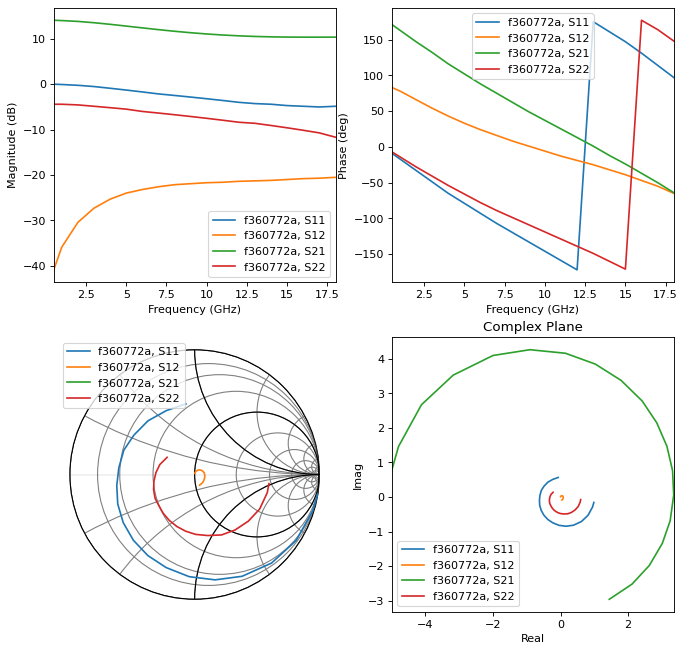

In [3]:
f360772a = rf.Network('f360772a.s2p')
plt.figure(figsize=(10, 10), dpi=80)
f360772a.plot_it_all()
begin=f360772a

In [4]:
freq=8 #GHz
noisefig=0.4 #dB
gamma_opt = P2R(0.66,102)
fmin = 0.37 #dB
z0=f360772a.z0[freq][0].real
rn = 0.09*z0 #noise resistance
s11,s12=f360772a.s[freq].tolist()[0]
s21,s22=f360772a.s[freq].tolist()[1]
print(s11,s12,s21,s22)

(-0.37499999999999983-0.649519052838329j) (0.07724090936184248+0.010855501874885104j) (1.793381369842103+3.3728598047211005j) (-0.07195985391850618-0.4543366366737634j)


# check stability

In [5]:
rollet(s11,s12,s21,s22)
_=mou(s11,s12,s21,s22)

delta: (-0.3700236786079713-0.06287527837717541j)
k: 0.6154699009289547 |delta|: 0.3753276213677626
potentially unstable check stable circules
delta: (-0.3700236786079713-0.06287527837717541j)
mou: 0.6793775590085922


out ( R: 4.212688654969572 C: (4.892066213978165, 136.6371278490927) )
in ( R: 0.7066873369048792 C: (1.5392519490346264, 131.51854068582625) )
hole smith except circles
for unconditionally stable we need rin: 20.0 Ohm rout: 11.0 Ohm


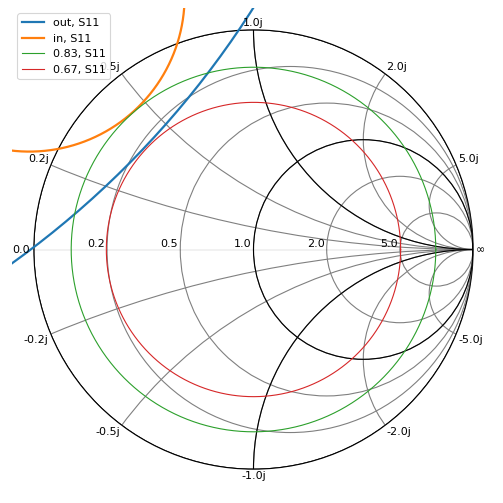

In [6]:
R=[0.83,0.67]
plotstablecircules(s11,s12,s21,s22,R)
#read it from chart
rin=(z0*0.4).real
rout=(z0*0.22).real
print("for unconditionally stable we need rin:",rin,"Ohm","rout:",rout,"Ohm")

# update network

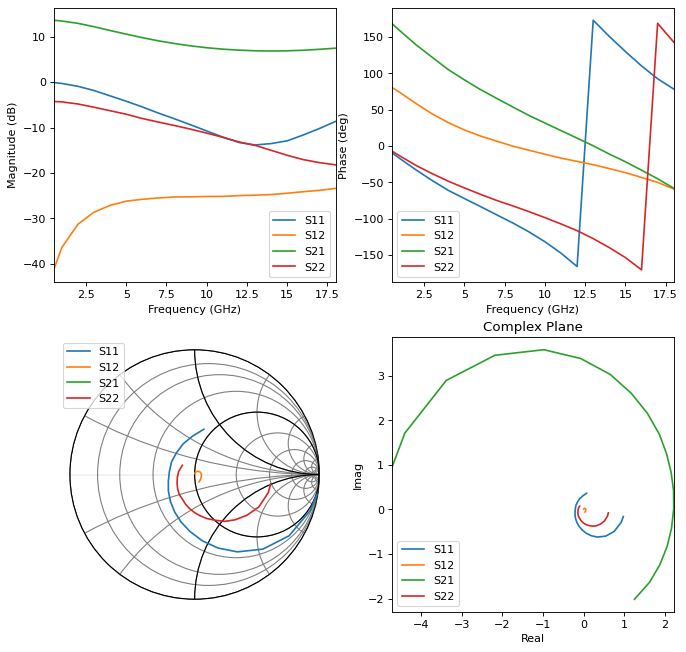

In [7]:
line = rf.media.DefinedGammaZ0(frequency=f360772a.frequency, z0=50)
f360772a=line.resistor(rin) ** f360772a ** line.resistor(rout)
plt.figure(figsize=(10, 10), dpi=80)
f360772a.plot_it_all()

In [8]:
s11,s12=f360772a.s[freq].tolist()[0]
s21,s22=f360772a.s[freq].tolist()[1]
rollet(s11,s12,s21,s22)
mou(s11,s12,s21,s22)

delta: (-0.2168128595693998-0.09800237218533933j)
k: 2.709851803799607 |delta|: 0.23793335417426043
unconditionally stable
delta: (-0.2168128595693998-0.09800237218533933j)
mou: 2.0821741473529816
unconditionally stable


2.0821741473529816

Maximum Available Gain : 9.71596461879021 dB
out ( R: 2.6569761928340556 C: (4.739150340187036, 93.75315871687559) )
in ( R: 1.4537060961316495 C: (3.315406096924476, 113.37358721938666) )
hole smith except circles


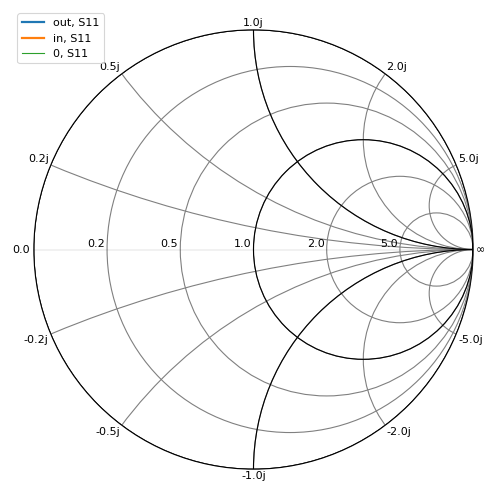

In [9]:
print("Maximum Available Gain :",MAG(s11,s12,s21,s22),"dB")
R=[0]
plotstablecircules(s11,s12,s21,s22,R)

# Ploting MOU in diffrent frequencys 

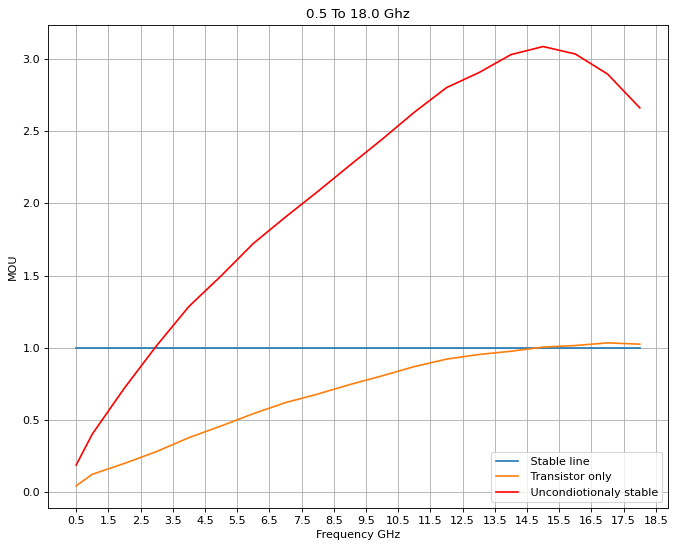

In [10]:
fewquencylist=begin.frequency.f
fewquencylist=fewquencylist/(10**9)
moulist,moulist2=[],[]

s11list=begin.s11.s
s12list=begin.s12.s
s21list=begin.s21.s
s22list=begin.s22.s
for i in range(len(fewquencylist)):   
     moulist.append(mou(s11list[i],s12list[i],s21list[i],s22list[i],verbus=False))
moulist=np.concatenate( moulist, axis=0 )     

s11list=f360772a.s11.s
s12list=f360772a.s12.s
s21list=f360772a.s21.s
s22list=f360772a.s22.s
for i in range(len(fewquencylist)):   
     moulist2.append(mou(s11list[i],s12list[i],s21list[i],s22list[i],verbus=False))
moulist2=np.concatenate( moulist2, axis=0 )  

plt.figure(figsize=(10, 8), dpi=80)
plt.grid(visible=True, which='major', axis='both')
plt.plot(fewquencylist,np.ones(len(fewquencylist)),label=' Stable line')
plt.plot(fewquencylist, moulist,label=' Transistor only')
plt.plot(fewquencylist, moulist2,label=' Uncondiotionaly stable',color='red')
plt.title(str(begin.frequency.start/10**9)+' To '+str(begin.frequency.stop/10**9)+' Ghz')
plt.xlabel('Frequency GHz')
plt.ylabel('MOU')
plt.legend(loc=4)
#specify axis tick step sizes
plt.xticks(np.arange(min(fewquencylist), max(fewquencylist)+1, 1))
plt.show()

# Noise circules
the minimum noise figure of the raw device could be obtained if gama_opt = S11*

the optimum source reflection coefficient is  (-0.13722171593972118+0.6455774164843118j)


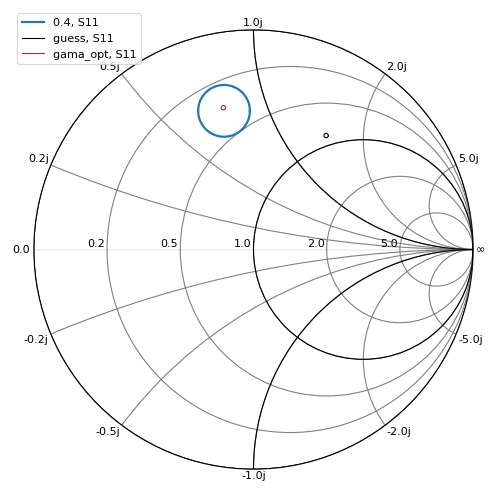

In [11]:
guess=(0.3309+0.5188j)
noisecircle(rn,gamma_opt,fmin,noisefig,guess)

# finding gama S
maximum power gain is obtained at the point gamas & minimum noise figure is obtained at gamas=gama_opt which might be imposible to reach both simultaneously

gamas read from smith chart : (0.06726727939963124, 42.27368900609374)


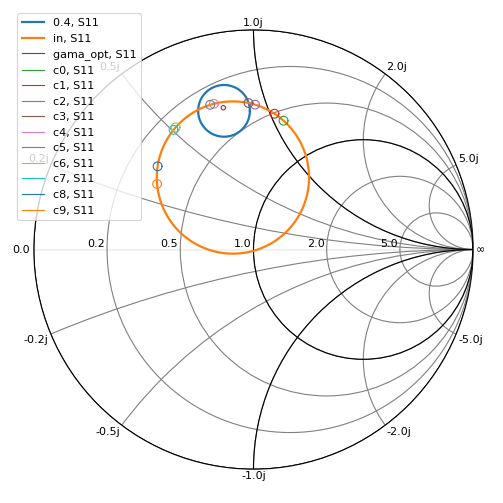

In [12]:
#zs=55-53j
zs=55+5j
gs=gamas(zs)
Volunteer=gain_noise(gs,noisefig)
guess=Volunteer[3]

# finding gamma L

gs: (0.049773755656108594+0.04524886877828054j) gl: (-0.056869990650773805+0.24849459734902557j) 
zs: (55+5j) zl: (39.66222982943049+21.081665574741812j)


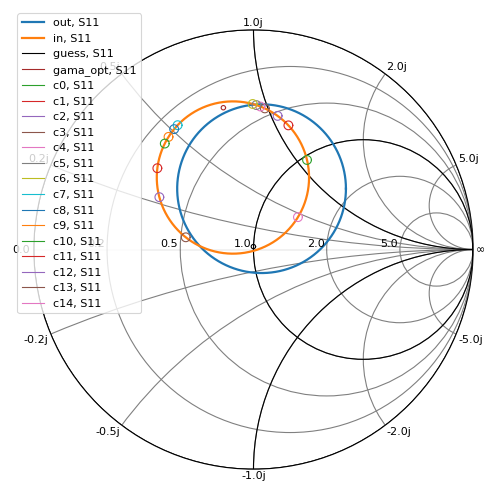

In [13]:
#gl=0.01+0.02j
gl=gamal(guess)
zl=findzfromgama(gl)[0]
print('gs:',gs,'gl:',gl,'\nzs:',zs,'zl:',zl)
C=gain_ciecles(s11,gs,s22,gl,guess/z0)

# update Z
Z11 is called input driving point Impedance

Z12 is called forward transfer Impedance

Z21 is called reverse transfer Impedance

Z22 is called output driving point Impedance.

For a network to be symmetrical , Z11 = Z22

For a network to be reciprocal, Z12 = Z21

In [14]:
z11=rf.network.s2z(f360772a.s11.s,z0)
z22=rf.network.s2z(f360772a.s22.s,z0)
if (z11!=z22).all() :
    print("network is reciprocal")    
else:
    print("network is symmetrical")
zl=rf.network.s2z(gl.reshape(1,1,1),z0)[0][0][0]   
zs=rf.network.s2z(np.array(guess).reshape(1,1,1),z0)[0][0][0] 
print('zs:',zs,'zl:',zl)

network is reciprocal
zs: (18.594081022370766+44.74198888845368j) zl: (39.66222982943048+21.08166557474181j)


# Defining zin and zout 
for gamas>1 and gamal>1

In [15]:
zout=-zl
zin=-zs
zin=findzin(zs)
zout=findzout(zl)
print("Zin is:",zin,"Zout is:",zout)

Zin is: (-18.594081022370766-44.74198888845368j) Zout is: (-39.66222982943048-21.08166557474181j)


# summary

Transducer Gain (Total): 7.585479850201705 dB lossed gain: 2.130484768588505 dB
input SWR: 1.1442369886119863 output SWR: 1.6842723649412628
gama S: (0.6674815087351283, 91.95103903074771) gama L: (0.25491912589735877, 102.89060777398157)


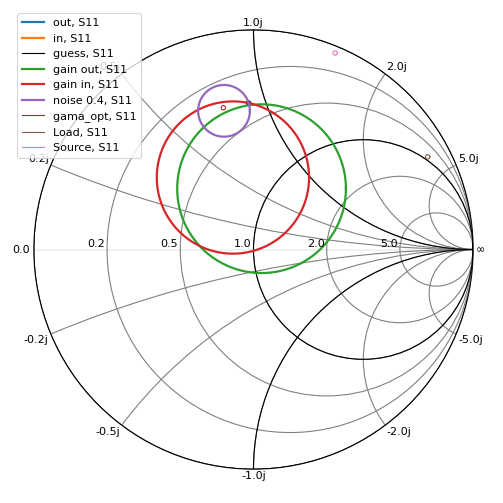

In [16]:
summary(gs,gl,noisefig,zs,zl)
print('Transducer Gain (Total):',GT(s11,s12,s21,s22,guess,gl),'dB','lossed gain:',MAG(s11,s12,s21,s22)-GT(s11,s12,s21,s22,guess,gl),"dB")
print('input SWR:',swr(gs),'output SWR:',swr(gl))
print('gama S:',R2P(guess),'gama L:',R2P(gl))

# Matching

In [349]:
#https://www.mathworks.com/help/rf/ug/designing-matching-networks-part-1-networks-with-an-lna-and-lumped-elements.html
#https://scikit-rf.readthedocs.io/en/latest/examples/circuit/Lumped%20Element%20Circuits.html
#https://www.allaboutcircuits.com/tools/l-match-impedance-matching-circuits/
gs=guess

# Matching with Lumped Elements in output

jx1 1.964980027946176e-14 Capacitor jx2 1.0156755959333421e-11 Inductor restype inductor res 4.7184051506638527e-11 Q: 0.5105342384983397


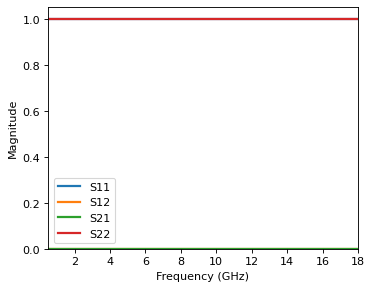

In [350]:
outputpkg =L_match(np.conj(zl),z0,freq*10**9)
plt.figure(figsize=(5, 4), dpi=80)
outputpkg[0].plot_s_mag(lw=2)
plt.ylim(bottom=0)
plt.show()

# Matching with Lumped Elements in input

jx1 4.116300165340558e-11 Inductor jx2 1.0342095158422993e-14 Capacitor restype inductor res 2.223232402127406e-11 Q: 1.2996260068971295


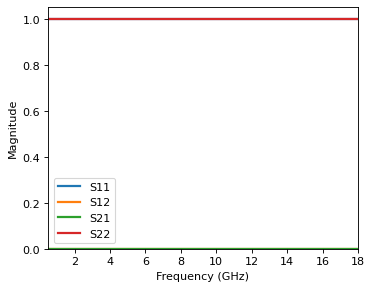

In [351]:
inputpkg =L_match(z0,np.conj(zs),freq*10**9)
plt.figure(figsize=(5, 4), dpi=80)
inputpkg[0].plot_s_mag(lw=2)
plt.ylim(bottom=0)
plt.show()

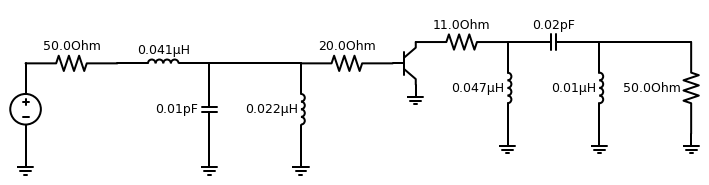

In [352]:
d=plotscheme(zs,zl,rin,rout,inputpkg,outputpkg)
d.draw()

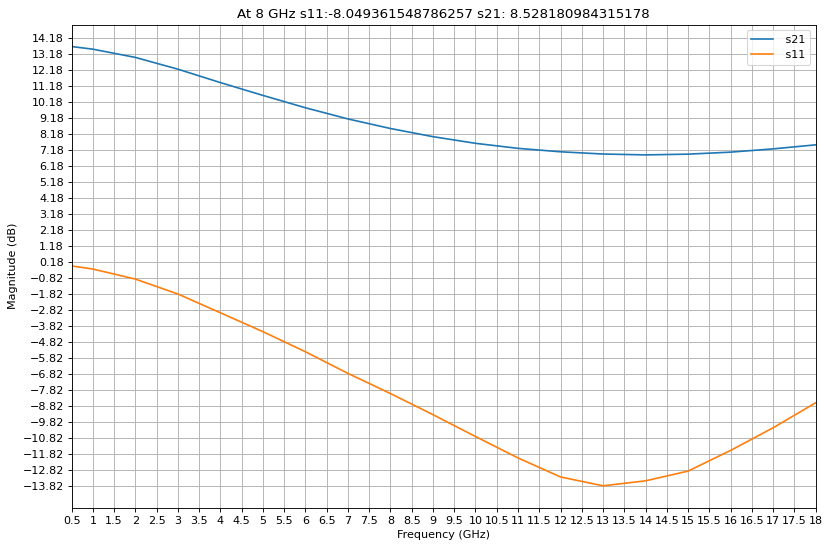

In [353]:
plt.figure(figsize=(12, 8), dpi=80)
plt.grid(visible=True, which='major', axis='both')
f360772a.s21.plot_s_db(label=' s21')
f360772a.s11.plot_s_db(label=' s11')
#specify axis tick step sizes
fewquencylist=f360772a.frequency.f
#fewquencylist=fewquencylist/(10**9)
plt.xticks(np.arange(min(fewquencylist), max(fewquencylist)+1, 10**9/2))
plt.yticks(np.arange(min(f360772a.s11.s_db), max(f360772a.s21.s_db)+1, 1))
plt.title('At '+str(freq)+' GHz s11:'+str(DB20(f360772a.s[freq].tolist()[0][0]))+' s21: '+str(DB20(f360772a.s[freq].tolist()[1][0])))
plt.show()

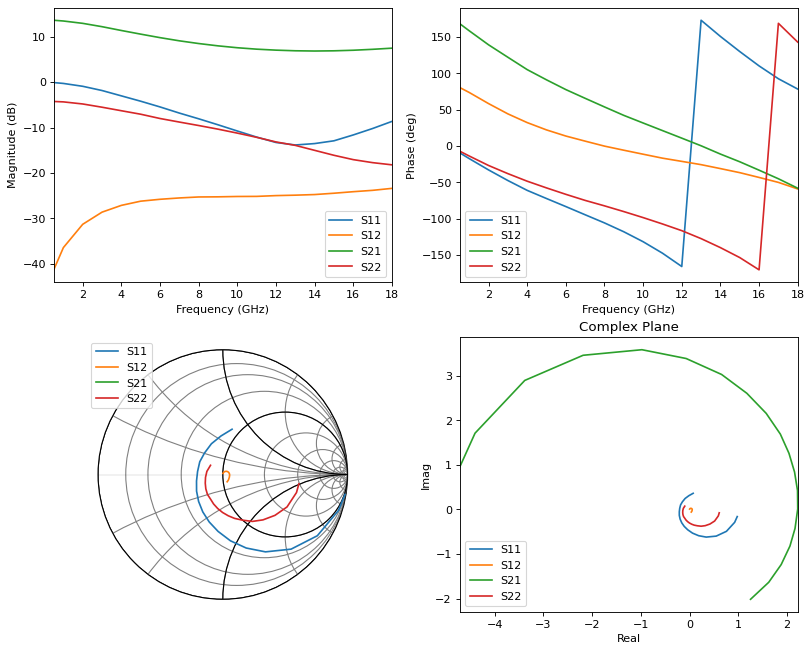

In [354]:
plt.figure(figsize=(12, 10), dpi=80)
f360772a.plot_it_all()

# Output matching network

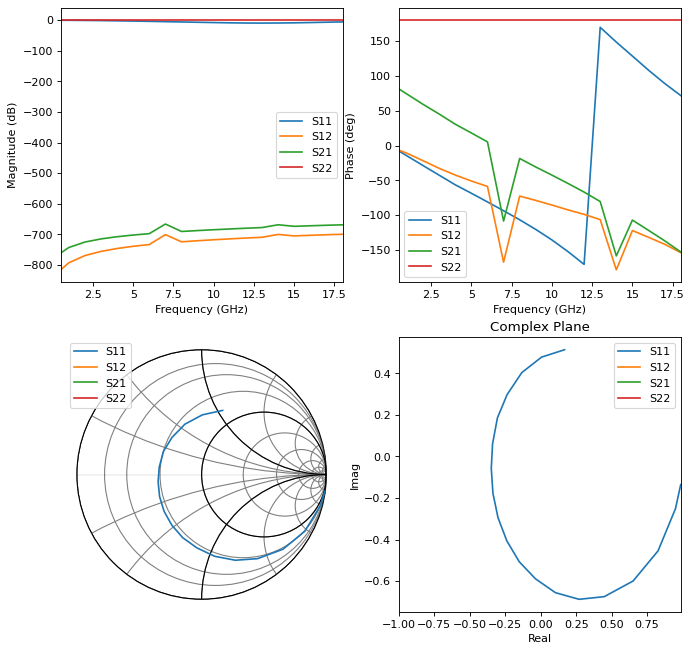

In [355]:
plt.figure(figsize=(10, 10), dpi=80)
amplifier = f360772a ** outputpkg[0]
amplifier.plot_it_all()

# Input matching network

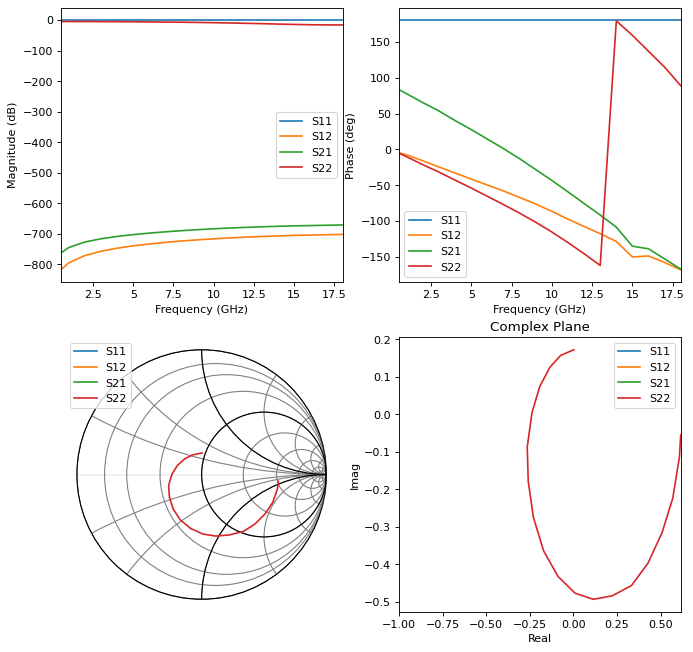

In [356]:
plt.figure(figsize=(10, 10), dpi=80) 
amplifier = inputpkg[0] ** f360772a 
amplifier.plot_it_all()

# complete circuit

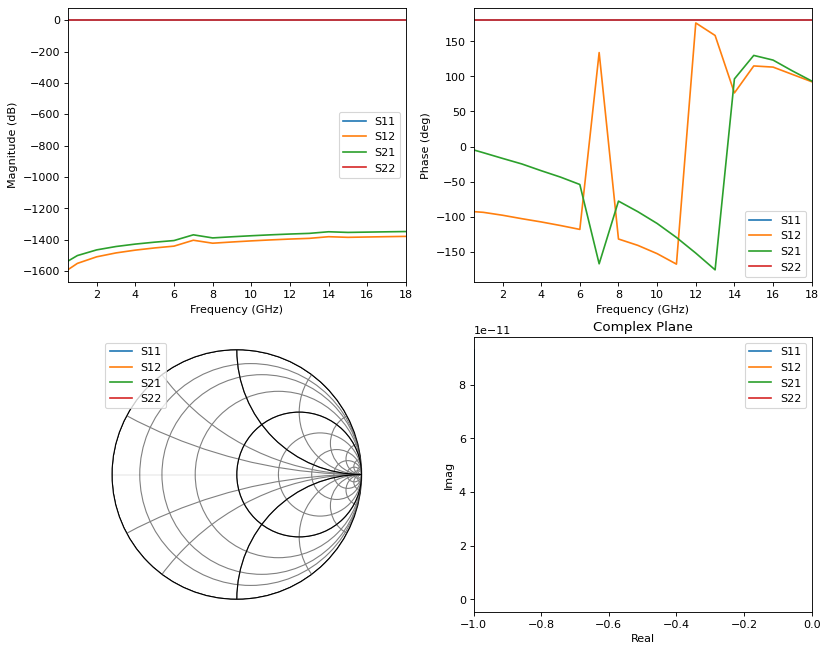

In [357]:
amplifier = inputpkg[0] ** f360772a ** outputpkg[0]
plt.figure(figsize=(12, 10), dpi=80)
plt.grid(visible=True, which='major', axis='both')
#amplifier.s21.plot_s_db(label=' s21')
#amplifier.s11.plot_s_db(label=' s11')
amplifier.plot_it_all()

In [358]:
s11,s12=f360772a.s[freq].tolist()[0]
s21,s22=f360772a.s[freq].tolist()[1]
rollet(s11,s12,s21,s22)
_=mou(s11,s12,s21,s22)

delta: (-0.2168128595693998-0.09800237218533933j)
k: 2.709851803799607 |delta|: 0.23793335417426043
unconditionally stable
delta: (-0.2168128595693998-0.09800237218533933j)
mou: 2.0821741473529816
unconditionally stable


In [359]:
print('Transducer Gain (Total):',GT(s11,s12,s21,s22,guess,gl),'dB','lossed gain:',MAG(s11,s12,s21,s22)-GT(s11,s12,s21,s22,guess,gl),"dB")

Transducer Gain (Total): 7.585479850201705 dB lossed gain: 2.130484768588505 dB


# Thermal Noise
Thermal noise is the most common noise introduced in an RF system. This noise is generated internally by active components in the system or externally due to channel interference or antenna. Thermal noise is also known as Johnson or Nyquist noise. 

Pn=Kb *T *B 

kb is Boltzmann's constant  1.38065 × 10-23 J/K

T is the noise temperature

B is the bandwidth

In [360]:
import pandas as pd
Temp=[15,20,25,30,35,40,45,50,55,60] # celcious
snr=4 # dB C/N
freq_step=f360772a.frequency.f[1]-f360772a.frequency.f[0]
s21_list=f360772a.s21.s
bandwidthl,ktbl,noisefloorl,nfl,sensl=[],[],[],[],[]
print('input SNR {} dB output SNR {} db'.format(snr,snr/FDB10(noisefig)))
for T in Temp:
    nfl.append(noisefig)
    bandwidth=Bandwidth(s21_list,freq_step)[0]
    ktb=KTB(T,bandwidth)[0]
    noisefloor=Thermal_noise_floor(T,bandwidth)[0]
    sens=sensitivity(T,bandwidth,noisefig,snr)[0]
    bandwidthl.append(bandwidth[0]/(10**9))
    ktbl.append(ktb)
    noisefloorl.append(noisefloor)
    sensl.append(sens)
data={
    'Temp C':Temp,
    'Bandwidth GHz':bandwidthl,
    'KTB':ktbl,
    'Thermal_noise_floor dBm':noisefloorl,
    'NF dB':nfl,
    'Sensitivity dBm':sensl
}
pd.DataFrame.from_dict(data)

input SNR 4 dB output SNR 3.64963503649635 db


,Temp C,Bandwidth GHz,KTB,Thermal_noise_floor dBm,NF dB,Sensitivity dBm
0,15,18.807823,7.482397e-11,-71.259592,0.4,-63.963828
1,20,18.807823,7.612232e-11,-71.184880,0.4,-63.925313
2,25,18.807823,7.742067e-11,-71.111431,0.4,-63.887136
3,30,18.807823,7.871902e-11,-71.039203,0.4,-63.849293
4,35,18.807823,8.001738e-11,-70.968157,0.4,-63.811775
5,40,18.807823,8.131573e-11,-70.898255,0.4,-63.774580
6,45,18.807823,8.261408e-11,-70.829459,0.4,-63.737700
7,50,18.807823,8.391243e-11,-70.761737,0.4,-63.701131
8,55,18.807823,8.521078e-11,-70.695055,0.4,-63.664867
9,60,18.807823,8.650913e-11,-70.629381,0.4,-63.628903


# Voltages and Currents in Circuits

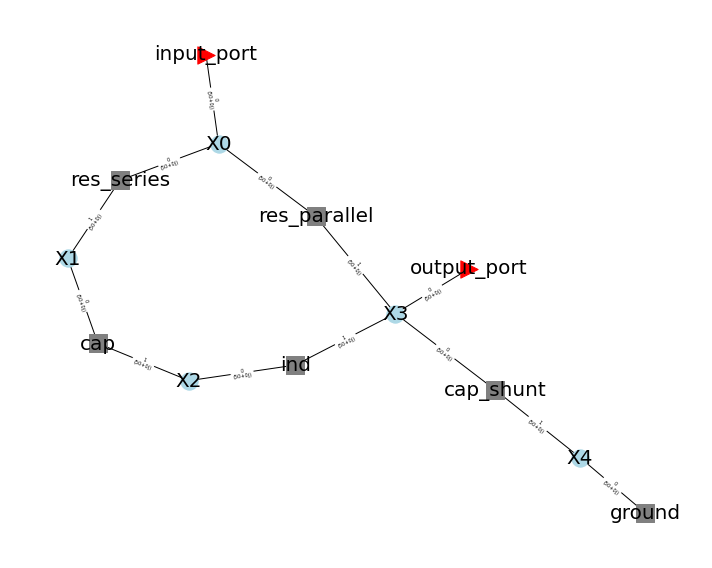

In [317]:
freq = f360772a .frequency
port1 = rf.Circuit.Port(frequency=freq, name='input_port', z0=50)
port2 = rf.Circuit.Port(frequency=freq, name='output_port', z0=50)
line = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
cap = line.capacitor(70e-12, name='cap')
ind = line.inductor(24e-9, name='ind')
res_series = line.resistor(1e-2, name='res_series')
res_parallel = line.resistor(20e6, name='res_parallel')
cap_shunt = line.capacitor(50e-12, name='cap_shunt')
ground = rf.Circuit.Ground(frequency=freq, name='ground', z0=50)

connections = [
    [(port1, 0), (res_series, 0), (res_parallel, 0)],
    [(res_series, 1), (cap, 0)],
    [(cap, 1), (ind, 0)],
    [(ind, 1), (cap_shunt, 0), (res_parallel, 1), (port2, 0)],
    [(cap_shunt, 1), (ground, 0)],
]
circuit = rf.Circuit(connections)
LCC_from_circuit = circuit.network
circuit.plot_graph(network_labels=True, edge_labels=True, port_labels=True,inter_labels=True,network_fontsize=20,edges_fontsize=20,port_fontsize=20)

In [318]:
power = [1, 0]  # 1 Watt at port1 and 0 at port2
phase = [0, 0]  # 0 radians
V_at_ports = circuit.voltages_external(power, phase)
print(V_at_ports)
I_at_ports = circuit.currents_external(power, phase)
print(I_at_ports)

[[ 1.24760618e+01+9.56432825e+00j -1.07831364e+00-1.09527273e+00j]
 [ 1.78767154e+01+6.14632241e+00j -3.81136999e-01-1.59436430e-01j]
 [ 1.94547915e+01+3.25464801e+00j -1.02941950e-01-2.06312691e-02j]
 [ 1.97565050e+01+2.19236271e+00j -4.63928405e-02-6.15161085e-03j]
 [ 1.98627867e+01+1.65021228e+00j -2.62225454e-02-2.60116276e-03j]
 [ 1.99120988e+01+1.32237053e+00j -1.68199677e-02-1.33335111e-03j]
 [ 1.99389171e+01+1.10297188e+00j -1.16947019e-02-7.72194135e-04j]
 [ 1.99550984e+01+9.45919528e-01j -8.59830460e-03-4.86558549e-04j]
 [ 1.99656050e+01+8.27972118e-01j -6.58619760e-03-3.26118252e-04j]
 [ 1.99728102e+01+7.36153500e-01j -5.20559991e-03-2.29150615e-04j]
 [ 1.99779650e+01+6.62652927e-01j -4.21751558e-03-1.67128544e-04j]
 [ 1.99817795e+01+6.02488956e-01j -3.48614915e-03-1.25625968e-04j]
 [ 1.99846811e+01+5.52335371e-01j -2.92971655e-03-9.68119732e-05j]
 [ 1.99869394e+01+5.09886703e-01j -2.49658043e-03-7.61849010e-05j]
 [ 1.99887313e+01+4.73494716e-01j -2.15283746e-03-6.10314031e-